**The PaySim synthetic financial datasets for fraud detection provide a good basis for exploring what can be done with transactional financial data. We use this set here to walkthrough a standard analysis around a classification problem using structured data and discuss approach, results and improvements.** (https://www.kaggle.com/datasets/ealaxi/paysim1)

To download the dataset from kaggle, we use the package kagglehub and then read the data into a pandas dataframe. We check the top rows to see that the data has loaded successfully.

In [3]:
import kagglehub
import pandas as pd

# Download latest version of paysim synthetic fraud dataset
path = kagglehub.dataset_download("ealaxi/paysim1")

df_all = pd.read_csv(path + "/PS_20174392719_1491204439457_log.csv")
print(df_all.head())

print(f"Shape of dataframe: {df_all.shape}")

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
Shape of dataframe: (6362620, 11)


*For performance reasons we limit the actions taken in this notebook to around 100'000 rows. We will filter up to the step when this number of rows is reached.*

In [4]:
step_limit = df_all['step'].values[99999]
df = df_all[df_all['step'] <= step_limit].copy()
print(f"Shape of dataframe: {df.shape}")

Shape of dataframe: (108717, 11)


1. Explorative Data Analysis: As a first step we check distributions, missing values, frequencies and correlations in order to both understand the data but also to recognize first patterns.

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
------------------


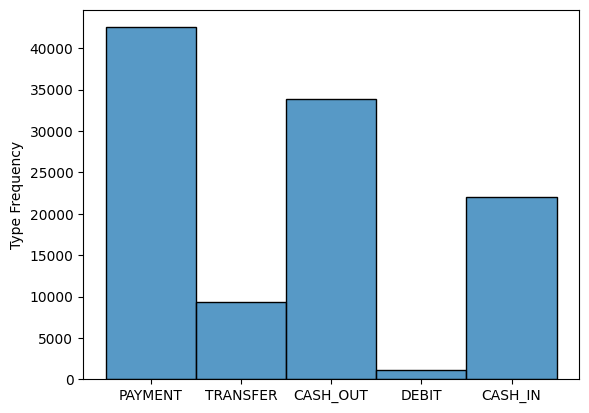

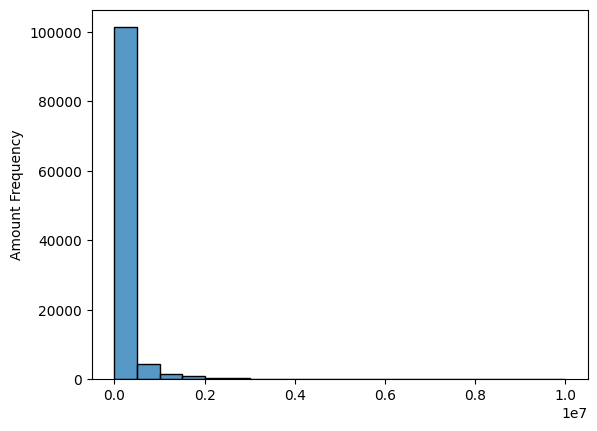

nameDest
C985934102     78
C1286084959    73
C248609774     72
C1590550415    71
C2083562754    68
C977993101     67
C665576141     66
C1360767589    63
C451111351     60
C97730845      58
Name: count, dtype: int64

isFraud
0    108597
1       120
Name: count, dtype: int64


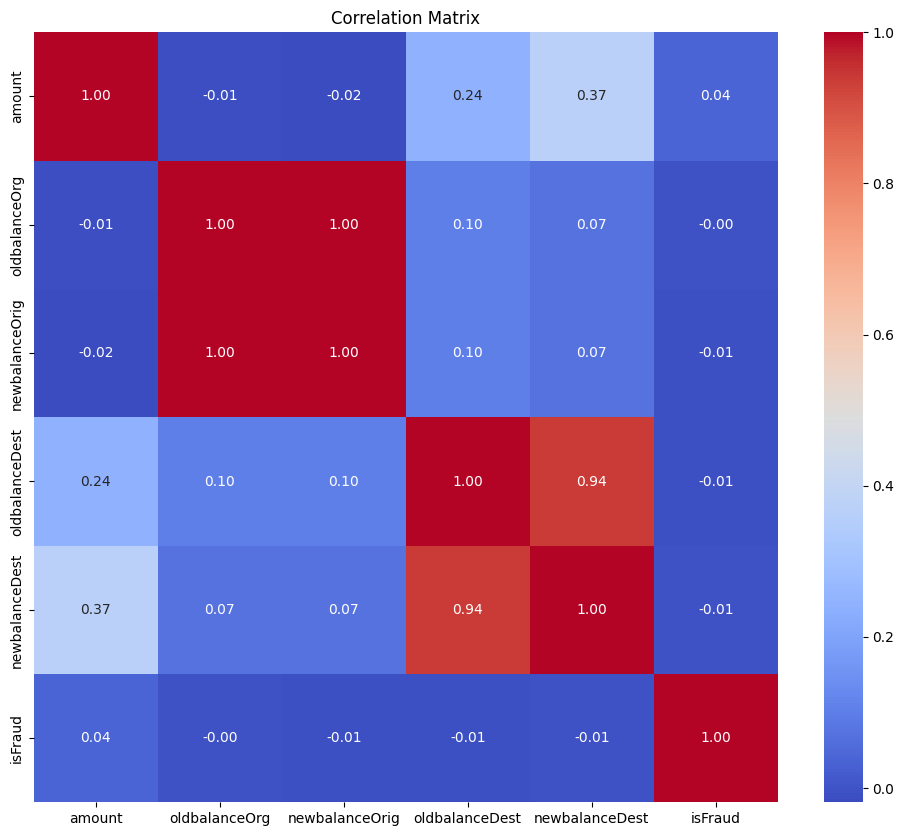

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Missing values
print(df.isnull().sum())
print("------------------")

# Histograms for type and amount
sns.histplot(df['type'].values)
plt.ylabel('Type Frequency')
plt.show()

sns.histplot(df['amount'].values, bins=20)
plt.ylabel('Amount Frequency')
plt.show()

# Frequency tables for nameDest and isFraud
top10_nameDest = df['nameDest'].value_counts().head(10)
print(top10_nameDest)
print()
print(df['isFraud'].value_counts())

# Correlation Matrix
selected_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']
subset_df = df.loc[:,selected_cols]
corr_matrix = subset_df.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


*There is no missing data. Most transactions are payments. There is a certain concentration on a few recipients and it seems there is a minimal indication that higher amounts could correlate to possible fraud.*

2. Train a classifier: We engineer additional features out of the existing columns and train and fine-tune XGBoost. Results are interpreted and suggestions for further improvements are noted down.

In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Setting the feature set
df['time_since_last_dest'] = df.groupby(['nameDest'])['step'].diff().fillna(0) # Add time since last being destination

X = df.drop(['isFraud', 'step', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

# One-hot encoding for qualitative variables
qualitative_vars = ['type']
X = pd.get_dummies(X, columns=qualitative_vars)

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# Train Model
model = XGBClassifier(eval_metric="logloss")
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32583
           1       0.83      0.61      0.70        33

    accuracy                           1.00     32616
   macro avg       0.92      0.80      0.85     32616
weighted avg       1.00      1.00      1.00     32616

[[32579     4]
 [   13    20]]


*XGBoost finds a decent precision and recall given that we have significantly limited the dataset before. Let's do some further analysis.*

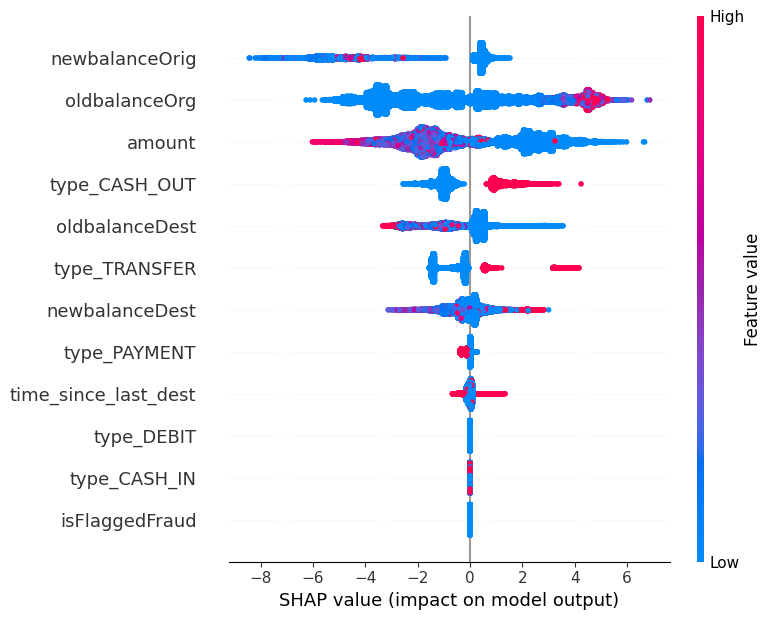

In [7]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

*The feature importance plot shows that high balances from the sender paired and low transactional amounts seem to indicate a higher chance of fraud. As this dataset was limited for performance reasons and was artifically created, a closer examination with an expert should be performed to verify the outcomes of this analysis.*

3. Next steps: With stronger computational resources, one would run the analysis with the complete data sample. Moreover there should be additional focus on the time series characteristics of this data set with additional features to be examined and further models (e.g. neural networks) to be tested in a CV Grid Search. 